In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from __future__ import annotations
from typing import Tuple, List, Dict

import os
import gc
from collections import namedtuple

import numpy as np

from scipy.spatial.distance import cdist

import torch
import metatensor

from halex.utils import tensormap_as_torch, shift_structure_by_n, drop_target_samples
from halex.rotations import ClebschGordanReal
from halex.hamiltonian import (
    compute_ham_features,
    drop_unused_features,
)
from halex.decomposition import EquivariantPCA
from halex.dataset import SCFData, BatchedMemoryDataset
from halex.models import RidgeOnEnergiesAndLowdinMultipleMolecules

from halex.train_utils import load_molecule_scf_datasets, compute_features, load_batched_dataset, coupled_fock_matrix_from_multiple_molecules

torch.set_default_dtype(torch.float64)

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('default')

In [3]:
def load_molecule_datasets(base_folder:str, mol: str, cg: ClebschGordanReal, indices: np.ndarray):
    """
    Load the SCFData objects storing data for a single molecule,
    in both a small basis and a big basis
    """
    coords_path = f"{base_folder}/{mol}/coords_{mol}_1000.xyz"
    small_basis_path = f"{base_folder}/{mol}/b3lyp_STO-3G/"
    big_basis_path = f"{base_folder}/{mol}/b3lyp_def2tzvp/"

    sb_data, bb_data = load_molecule_scf_datasets(
        coords_path=coords_path,
        small_basis_path=small_basis_path,
        big_basis_path=big_basis_path,
        cg=cg,
        train_indices=indices,
    )

    return sb_data, bb_data

In [4]:
def dataset_for_a_single_molecule(scf_datasets, nelec_dict):
    small_basis, big_basis = scf_datasets

    frames = small_basis.frames
    # truncate the big basis MO energies to the first n_small
    mo_energy = big_basis.mo_energy[:, : small_basis.mo_energy.shape[1]]
    # no need to truncate here as they refer to _occupied_ MOs
    lowdin_charges = big_basis.lowdin_charges
    lowdin_charges_bymo = big_basis.lowdin_charges_byMO
    # orbitals in the small basis (because we predict a small basis Fock)
    orbs = small_basis.orbs
    # ao labels in the small basis
    ao_labels = small_basis.ao_labels
    # baseline fock
    baseline_focks = small_basis.focks_orth
    
    dataset = namedtuple(
        'Dataset',
        field_names='frames mo_energy lowdin_charges lowdin_charges_bymo orbs ao_labels nelec_dict baseline_focks'.split(),
        defaults=[frames, mo_energy, lowdin_charges, lowdin_charges_bymo, orbs, ao_labels, nelec_dict, baseline_focks],
    )()
    
    return dataset

In [5]:
cg = ClebschGordanReal(4)

In [6]:
molecules = [
    "ethane",
    "ethene",
    # "butadiene",
    # "hexane",
    # "hexatriene",
    # "isoprene",
    # "styrene",
]

In [15]:
train_indices = np.load('train_output/train_indices.npy')
all_indices = np.arange(1000)
test_indices = np.setdiff1d(all_indices, train_indices)[:100] #[:40]
train_indices = train_indices[:1] # only one as we don't need them now

In [16]:
# Get datasets in small and big basis
train_datasets = {
    mol: load_molecule_datasets("CH-dataset", mol, cg=cg, indices=train_indices) # only one frame, used just to instantiate the model
    for mol in molecules
}

test_datasets = {
    mol: load_molecule_datasets("CH-dataset", mol, cg=cg, indices=test_indices)
    for mol in molecules
}

In [17]:
# ==================================================================
# Compute the Features
# ==================================================================

# compute features
rascal_hypers = {
    "interaction_cutoff": 3.5,
    "cutoff_smooth_width": 0.5,
    "max_radial": 6,
    "max_angular": 4,
    "gaussian_sigma_constant": 0.2,
    "gaussian_sigma_type": "Constant",
    "compute_gradients": False,
}

epca = EquivariantPCA(n_components=200).load("train_output/epca.npz")

train_feats = compute_features(train_datasets, rascal_hypers=rascal_hypers, cg=cg, lcut=2, epca=epca)

test_feats = compute_features(test_datasets, rascal_hypers=rascal_hypers, cg=cg, lcut=2, epca=epca)

gc.collect()

  0%|          | 0/2 [00:00<?, ?it/s]
transforming each tensormap key: 13it [00:00, 1521.97it/s]
 50%|█████     | 1/2 [00:00<00:00,  3.60it/s]
transforming each tensormap key: 13it [00:00, 2245.53it/s]
  0%|          | 0/2 [00:00<?, ?it/s]
transforming each tensormap key: 13it [00:00, 209.61it/s]
 50%|█████     | 1/2 [00:09<00:09,  9.81s/it]
transforming each tensormap key: 13it [00:00, 338.21it/s]
100%|██████████| 2/2 [00:16<00:00,  8.25s/it]


3086

In [18]:
nelec_dict = {"H": 1.0, "C": 6.0}

train_targ_coupled = coupled_fock_matrix_from_multiple_molecules(train_datasets.values())

In [19]:
tr_datasets = {
    mol: dataset_for_a_single_molecule(train_datasets[mol], nelec_dict)
    for i, mol in enumerate(molecules)
}

te_datasets = {
    mol: dataset_for_a_single_molecule(test_datasets[mol], nelec_dict)
    for i, mol in enumerate(molecules)
}

In [20]:
model = RidgeOnEnergiesAndLowdinMultipleMolecules(
    coupled_tmap=train_targ_coupled,
    features=metatensor.join(train_feats, axis='samples'),
    alpha=1e-16,
    bias=False,
)

path = os.path.join(
    "train_output/model_state_dict.pth",
)

model.load_state_dict(
    torch.load(path)
)

<All keys matched successfully>

In [21]:
from halex.hamiltonian import blocks_to_dense, decouple_blocks
from halex.popan import (
    batched_orthogonal_lowdin_population,
    batched_orthogonal_lowdinbyMO_population,
)

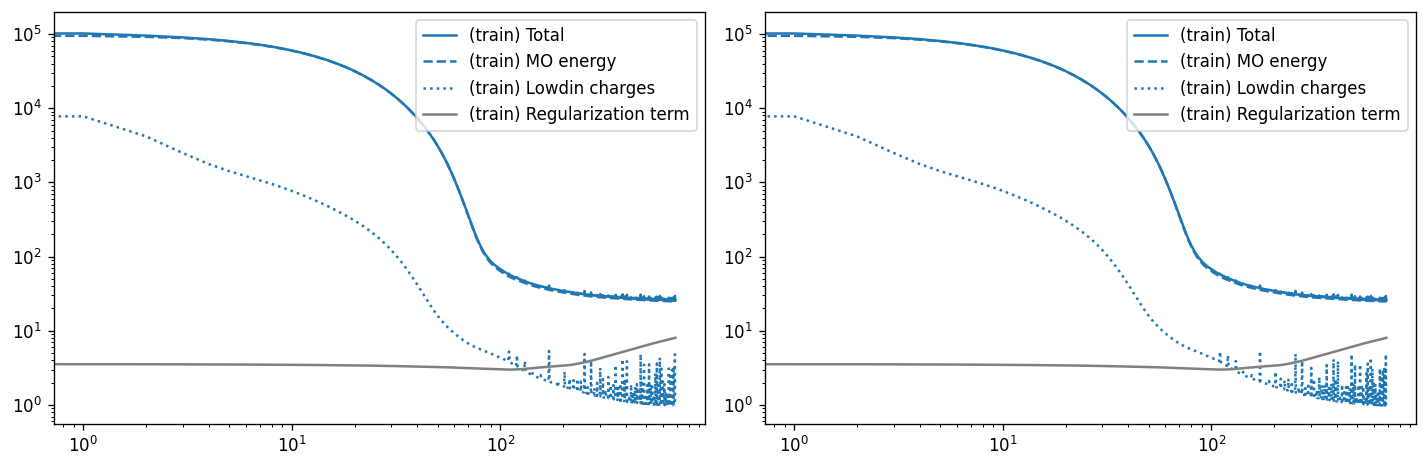

In [22]:
history = np.load("train_output/history.npz")

fig, axes = plt.subplots(1, 2, figsize=(6 * 2, 4), dpi=120)

ax = axes[0]
kind = 'train'
c = 'C0'
ax.loglog(history[f'{kind}_total'], label=f'({kind}) Total', c=c)
ax.loglog(history[f'{kind}_eig_loss'] * 1.51e6, label=f'({kind}) MO energy', c=c, ls='--')
ax.loglog(history[f'{kind}_low_loss'] * 1e6, label=f'({kind}) Lowdin charges', c=c, ls=':')
ax.loglog(history[f'{kind}_reg_loss'] * 1e6, label=f'({kind}) Regularization term', c='gray')
ax.legend()


# kind = 'valid'
# c='C1'
# ax.loglog(history[f'{kind}_total'], label=f'({kind}) Total', c=c)
# ax.loglog(history[f'{kind}_eig_loss'] * 1.51e6, label=f'({kind}) MO energy', c=c, ls='--')
# ax.loglog(history[f'{kind}_low_loss'] * 1e6, label=f'({kind}) Lowdin charges', c=c, ls=':')
# ax.legend()

ax = axes[1]
kind = 'train'
c = 'C0'
ax.loglog(history[f'{kind}_total'], label=f'({kind}) Total', c=c)
ax.loglog(history[f'{kind}_eig_loss'] * 1.51e6, label=f'({kind}) MO energy', c=c, ls='--')
ax.loglog(history[f'{kind}_low_loss'] * 1e6, label=f'({kind}) Lowdin charges', c=c, ls=':')
ax.loglog(history[f'{kind}_reg_loss'] * 1e6, label=f'({kind}) Regularization term', c='gray')
ax.legend()


# kind = 'valid'
# c='C1'
# ax.loglog(history[f'{kind}_total'], label=f'({kind}) Total', c=c)
# ax.loglog(history[f'{kind}_eig_loss'] * 1.51e6, label=f'({kind}) MO energy', c=c, ls='--')
# ax.loglog(history[f'{kind}_low_loss'] * 1e6, label=f'({kind}) Lowdin charges', c=c, ls=':')
# ax.legend()
# ax.set_xlim(100,)
# ax.set_ylim(1e0, 1e4)

fig.tight_layout()

In [23]:
def predict(model, dataset, features, core_features=None):
    
    frames = dataset.frames
    orbs = dataset.orbs
    nelec_dict = dataset.nelec_dict
    ao_labels = dataset.ao_labels
    
    focks_orth = blocks_to_dense(decouple_blocks(model(features, core_features), cg), frames, orbs, vectorized=True)
    # focks_orth = dataset.baseline_focks + delta_focks_orth
    mo_energy, mo_coeff_orth = torch.linalg.eigh(focks_orth)
    lowdin_charges, _ = batched_orthogonal_lowdin_population(focks_orth, nelec_dict, ao_labels)
    lowdin_charges_bymo, _ = batched_orthogonal_lowdinbyMO_population(focks_orth, nelec_dict, ao_labels)
    
    prediction = namedtuple(
        'Prediction',
        field_names='focks_orth mo_energy mo_coeff_orth lowdin_charges lowdin_charges_bymo'.split(),
        defaults=[focks_orth, mo_energy, mo_coeff_orth, lowdin_charges, lowdin_charges_bymo],
    )()
    
    return prediction

In [24]:
pred_train = {
    mol: predict(model, tr_datasets[mol], train_feats[i])
    for i, mol in enumerate(tr_datasets.keys())
}

In [25]:
pred_test = {
    mol: predict(model, te_datasets[mol], test_feats[i])
    for i, mol in enumerate(te_datasets.keys())
}

In [26]:
from ase.units import Hartree
from sklearn.metrics import mean_absolute_error, mean_squared_error

from halex.pyplot import set_equalaxes

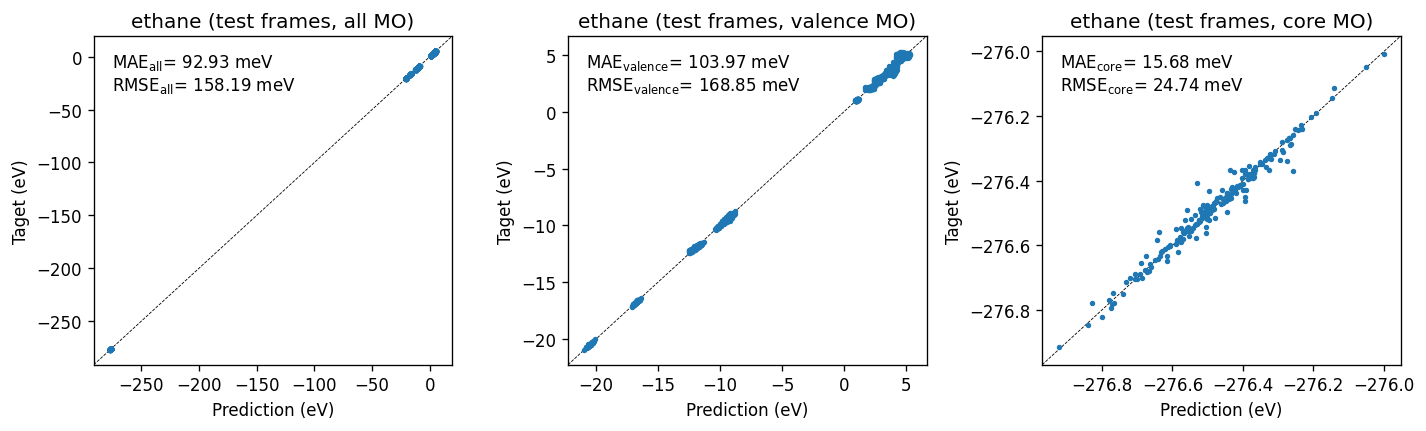

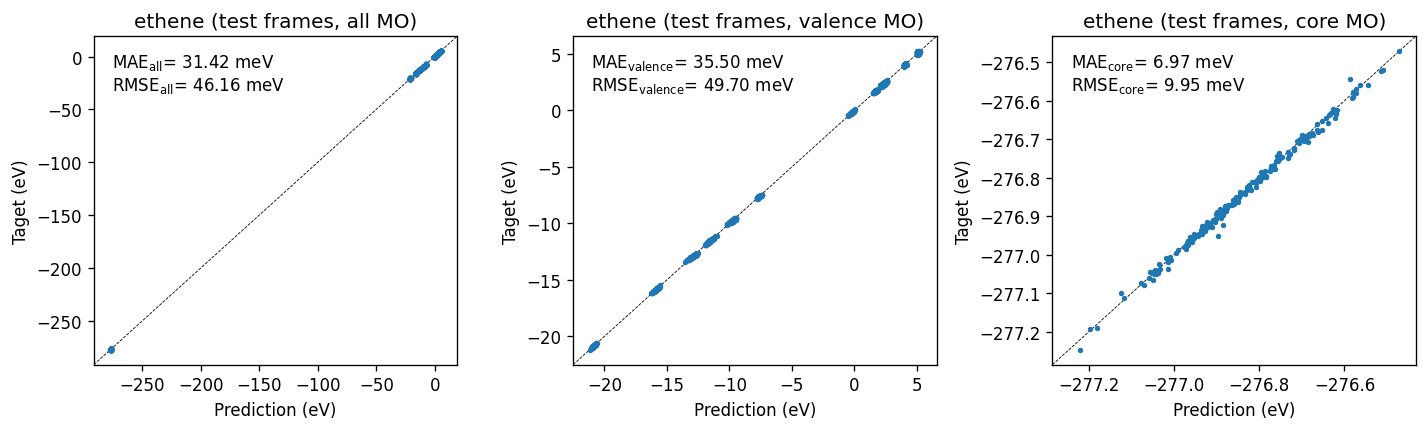

In [27]:
for mol in pred_test.keys():
    fig, axes = plt.subplots(1, 3, figsize=(4 * 3, 3.7), dpi=120)
    
    ax = axes[0]
    ax.plot([0, 1], [0, 1], ls='dashed', transform=ax.transAxes, c='k', zorder=-99, lw=.5)
    x = pred_test[mol].mo_energy.detach().numpy().reshape(-1) * Hartree
    y = te_datasets[mol].mo_energy.detach().numpy().reshape(-1) * Hartree
    mae = mean_absolute_error(x, y) * 1e3
    rmse = mean_squared_error(x, y) ** 0.5 * 1e3
    ax.scatter(x, y, s=5)
    ax.text(0.05, 0.95, r'MAE$_{\rm all}$' + f'= {mae:.2f} meV\n' + r'RMSE$_{\rm all}$' + f'= {rmse:.2f} meV', ha='left', va='top', transform=ax.transAxes)
    ax.set_title(f'{mol} (test frames, all MO)')
    ax.set_xlabel('Prediction (eV)')
    ax.set_ylabel('Taget (eV)')
    set_equalaxes(ax)
    
    ax = axes[1]
    ax.plot([0, 1], [0, 1], ls='dashed', transform=ax.transAxes, c='k', zorder=-99, lw=.5)
    x = pred_test[mol].mo_energy.detach().numpy().reshape(-1) * Hartree
    y = te_datasets[mol].mo_energy.detach().numpy().reshape(-1) * Hartree
    x = x[x>-50]
    y = y[y>-50]
    mae = mean_absolute_error(x, y) * 1e3
    rmse = mean_squared_error(x, y) ** 0.5 * 1e3
    ax.scatter(x, y, s=5)
    ax.text(0.05, 0.95, r'MAE$_{\rm valence}$' + f'= {mae:.2f} meV\n' + r'RMSE$_{\rm valence}$' + f'= {rmse:.2f} meV', ha='left', va='top', transform=ax.transAxes)
    ax.set_title(f'{mol} (test frames, valence MO)')
    ax.set_xlabel('Prediction (eV)')
    ax.set_ylabel('Taget (eV)')
    set_equalaxes(ax)
    
    ax = axes[2]
    ax.plot([0, 1], [0, 1], ls='dashed', transform=ax.transAxes, c='k', zorder=-99, lw=.5)
    x = pred_test[mol].mo_energy.detach().numpy().reshape(-1) * Hartree
    y = te_datasets[mol].mo_energy.detach().numpy().reshape(-1) * Hartree
    x = x[x<-50]
    y = y[y<-50]
    mae = mean_absolute_error(x, y) * 1e3
    rmse = mean_squared_error(x, y) ** 0.5 * 1e3
    ax.scatter(x, y, s=5)
    ax.text(0.05, 0.95, r'MAE$_{\rm core}$' + f'= {mae:.2f} meV\n' + r'RMSE$_{\rm core}$' + f'= {rmse:.2f} meV', ha='left', va='top', transform=ax.transAxes)
    ax.set_title(f'{mol} (test frames, core MO)')
    ax.set_xlabel('Prediction (eV)')
    ax.set_ylabel('Taget (eV)')
    set_equalaxes(ax)
   
    fig.tight_layout()

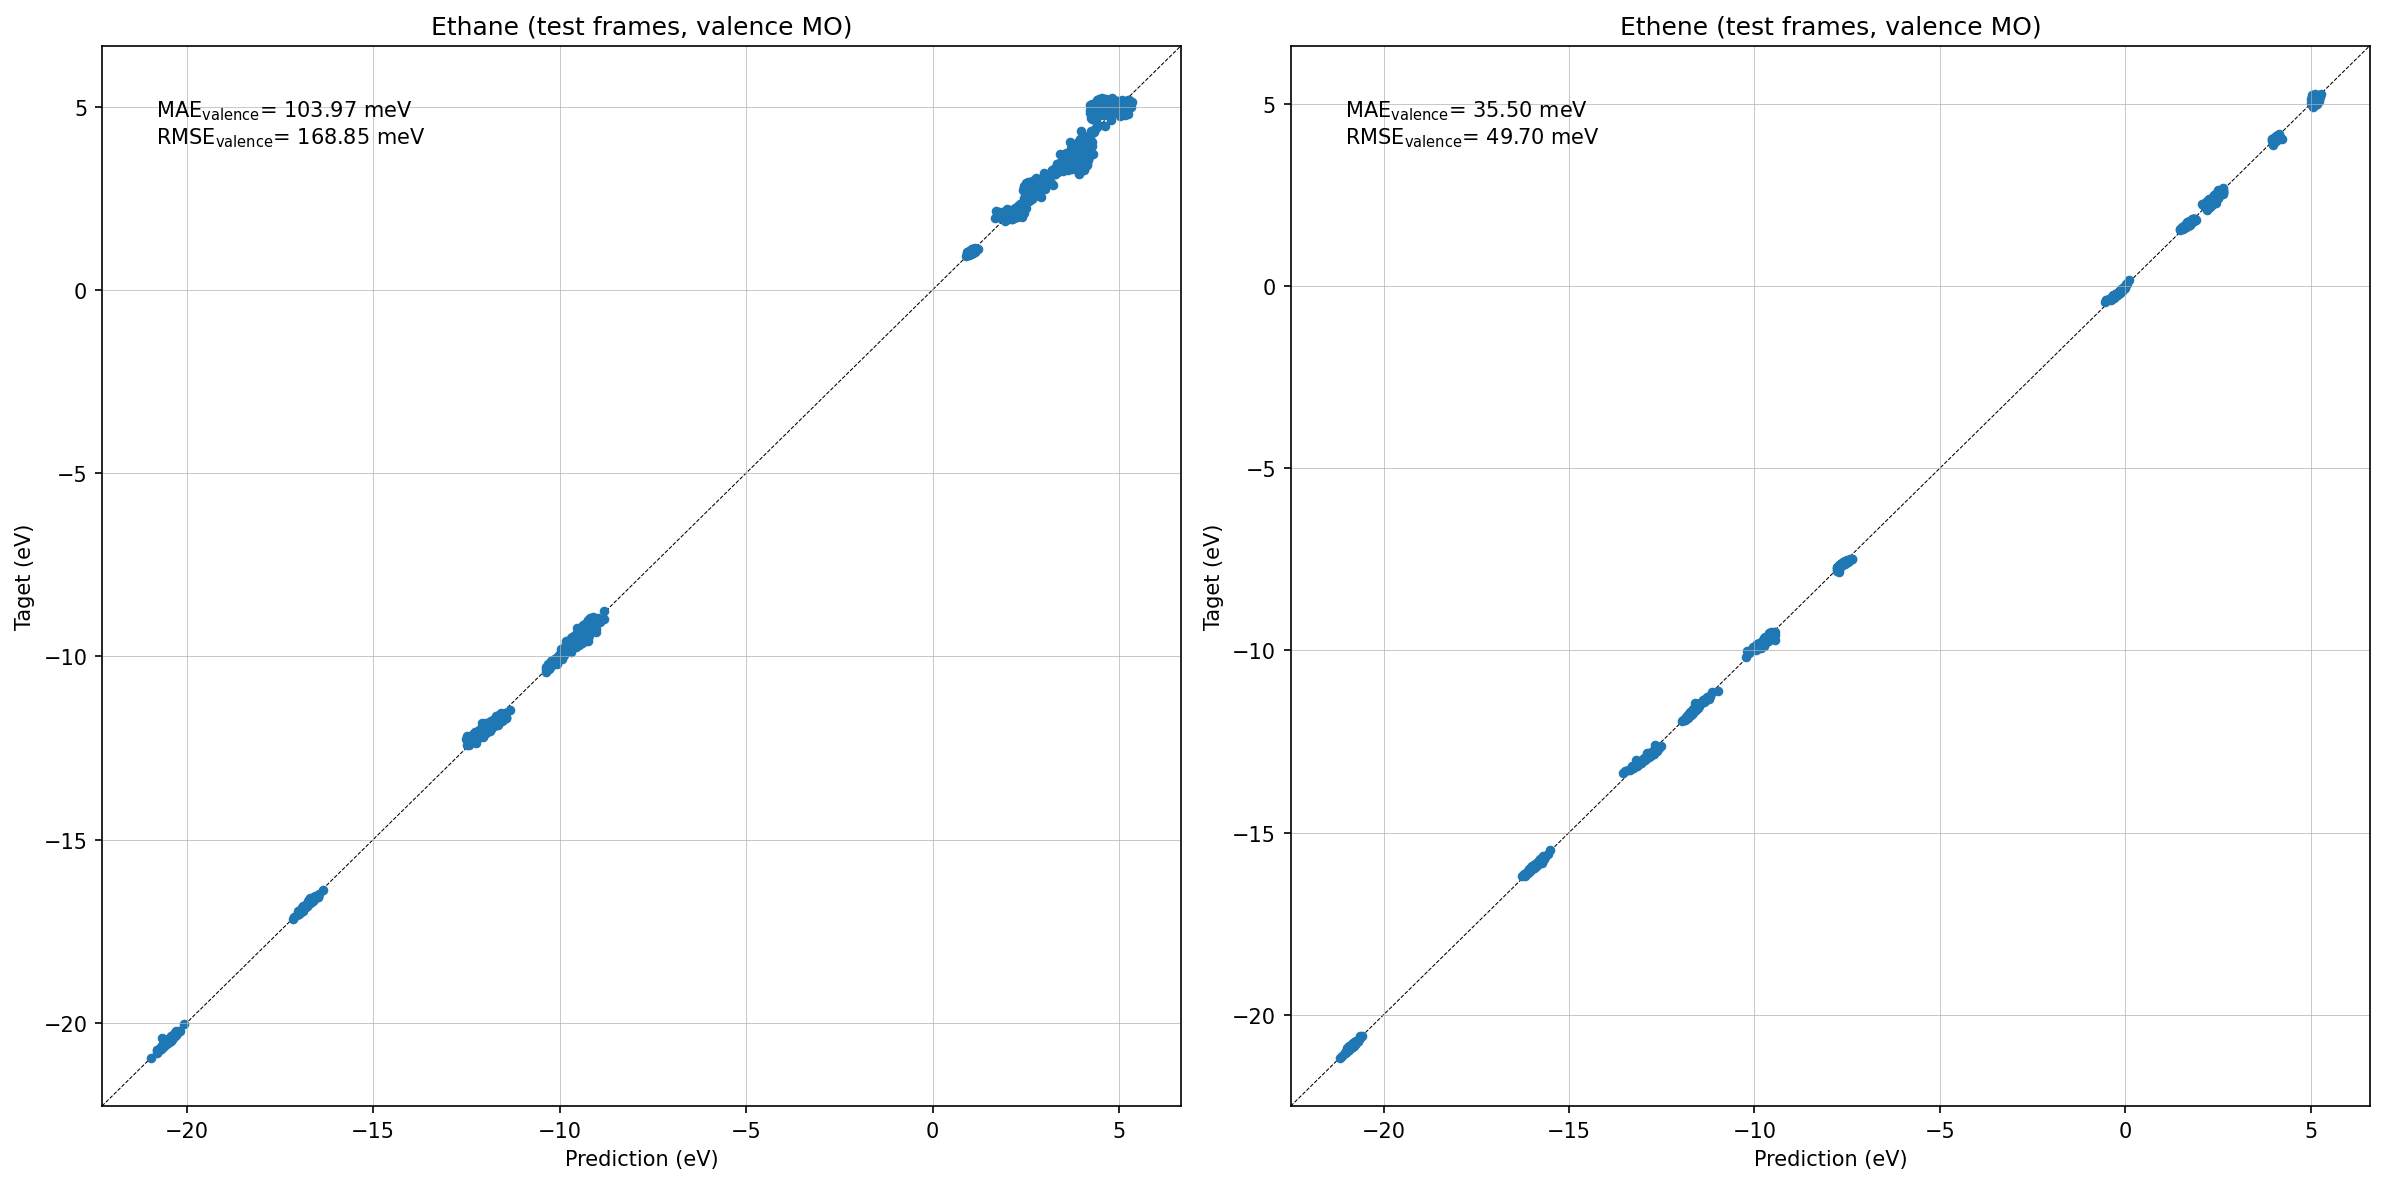

In [28]:
fig, axes = plt.subplots(1, 2, figsize=(4*4, 4*2), dpi=150)

for ax, mol in zip(axes.flat, pred_test.keys()):
    ax.grid(lw=.33)
    ax.plot([0, 1], [0, 1], ls='dashed', transform=ax.transAxes, c='k', zorder=-99, lw=.5)
    x = pred_test[mol].mo_energy.detach().numpy().reshape(-1) * Hartree
    y = te_datasets[mol].mo_energy.detach().numpy().reshape(-1) * Hartree
    x = x[x>-50]
    y = y[y>-50]
    mae = mean_absolute_error(x, y) * 1e3
    rmse = mean_squared_error(x, y) ** 0.5 * 1e3
    ax.scatter(x, y, s=13)
    ax.text(0.05, 0.95, r'MAE$_{\rm valence}$' + f'= {mae:.2f} meV\n' + r'RMSE$_{\rm valence}$' + f'= {rmse:.2f} meV', ha='left', va='top', transform=ax.transAxes)
    ax.set_title(f'{mol.capitalize()} (test frames, valence MO)')
    ax.set_xlabel('Prediction (eV)')
    ax.set_ylabel('Taget (eV)')
    set_equalaxes(ax)
    
#axes[-1][-1].axis('off')

fig.tight_layout()

# Lowdin charges

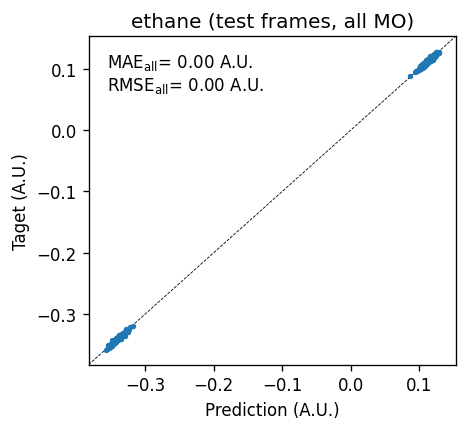

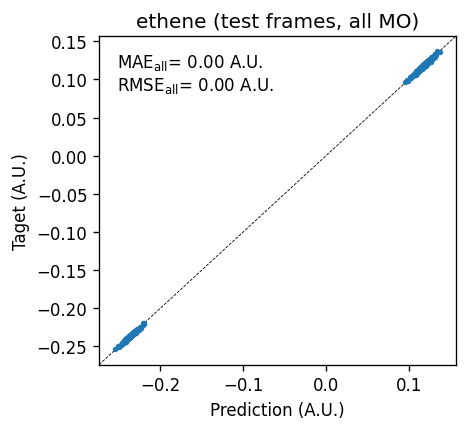

In [29]:
for mol in pred_test.keys():
    fig, ax = plt.subplots(1, 1, figsize=(4 * 1, 3.7), dpi=120)
    
    ax.plot([0, 1], [0, 1], ls='dashed', transform=ax.transAxes, c='k', zorder=-99, lw=.5)
    x = pred_test[mol].lowdin_charges.detach().numpy().reshape(-1)
    y = te_datasets[mol].lowdin_charges.detach().numpy().reshape(-1)
    mae = mean_absolute_error(x, y)
    rmse = mean_squared_error(x, y) ** 0.5 
    ax.scatter(x, y, s=5)
    ax.text(0.05, 0.95, r'MAE$_{\rm all}$' + f'= {mae:.2f} A.U.\n' + r'RMSE$_{\rm all}$' + f'= {rmse:.2f} A.U.', ha='left', va='top', transform=ax.transAxes)
    ax.set_title(f'{mol} (test frames, all MO)')
    ax.set_xlabel('Prediction (A.U.)')
    ax.set_ylabel('Taget (A.U.)')
    set_equalaxes(ax)
   
    fig.tight_layout()